In [1]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Conv2D, MaxPooling2D, Flatten
from keras.utils import np_utils
from keras import backend as K
from keras.utils.np_utils import to_categorical
from keras.utils.vis_utils import model_to_dot
from keras.optimizers import RMSprop, adam
from keras import backend as K
from keras.utils import np_utils
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator

import sklearn
from sklearn.tree import export_graphviz
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn import preprocessing 
from sklearn.utils import shuffle

from IPython.display import SVG

import csv
import os 
import cv2
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline 
import scipy as sp
import PIL
from PIL import Image

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder
from tensorflow.python.keras import callbacks
import tensorflow as tf
from sklearn.utils import class_weight

Using TensorFlow backend.


### Task1: Load the chest x-ray dataset and become familiar with its contents.

#### Data

Set up the data set process. We provide the name of a folder contianing images.
The images of differnet classes are contained in folders with class ids.

In [2]:
dataset_name = 'train/'

# assuming data is contained in a train and a test set
train_data_dir = dataset_name

# Set up some parameters for data loading
sample_rate = 0.5

# desired dimensions of our images.
img_width, img_height = 162, 128

# different backends
if K.image_data_format() == 'channels_first':
    input_shape = (3, img_width, img_height)
    input_shape_gray = (1,img_width, img_height)
else:
    input_shape = (img_width, img_height,3)
    input_shape_gray = (img_width, img_height,1)

#### Load image data.

In [3]:

training_class_folders = [i for i in os.listdir(train_data_dir) if not i.startswith('.')] # use this for full dataset
num_classes = len(training_class_folders)

# Initialise arrays for data storage

# X_data array for original image data
X_data = np.ndarray((0, input_shape[0], input_shape[1], input_shape[2]), dtype=np.float)
y_data= np.ndarray(0, dtype=np.str)

#  X_data_gray array for grayscale image data
X_data_gray = np.ndarray((0,input_shape_gray[0],input_shape_gray[1],input_shape_gray[2]),dtype=np.float)
    
# Loop through the class folders
for i, image_cls in enumerate(training_class_folders):
    
    print('Processing class {}'.format(image_cls))
    image_class_folder = train_data_dir + image_cls + "/"

    # generate filenames from the data folder and do sampling
    image_filenames = [image_class_folder+i for i in os.listdir(image_class_folder) if not i.startswith('.')] # use this for full dataset
    image_filenames = random.sample(image_filenames, int(len(image_filenames)*sample_rate))

    # Create a data array for image data
    count = len(image_filenames)
    X_data_part = np.ndarray((count, input_shape[0], input_shape[1], input_shape[2]), dtype=np.float)
    X_data_part_gray = np.ndarray((count, input_shape_gray[0], input_shape_gray[1], input_shape_gray[2]), dtype=np.float)
    

    # Iterate through the filenames and for each one load the image, resize and normalise
    for i, image_file in enumerate(image_filenames):

        # Load the images and resize them. 
        image = cv2.imread(image_file, cv2.IMREAD_COLOR)
        image_color = cv2.resize(image, (img_height, img_width), interpolation=cv2.INTER_CUBIC)
        image_color = image_color[:,:,[2,1,0]] 
        
        
        #gray scale image for Logistic Regression and CNN model
        
        image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        image_gray = cv2.resize(image_gray,(img_height, img_width), interpolation=cv2.INTER_CUBIC)
        image_gray = np.asarray(image_gray).reshape(image_gray.shape[0],image_gray.shape[1],1)
        
        # If channel order of network does not match open cv format swap it
        if K.image_data_format() == 'channels_first':
            image_color=np.swapaxes(np.swapaxes(image_color, 1, 2), 0, 1)
            image_gray=np.swapaxes(np.swapaxes(image_gray, 1, 2), 0, 1)
            
            
        # Add image data to data array and normalise
        X_data_part[i] = image_color
        X_data_part[i] = X_data_part[i]/255
        X_data_part_gray[i] = image_gray
        X_data_part_gray[i] = X_data_part_gray[i]/255
        
        # Add label to label array
        y_data = np.append(y_data, image_cls)
        
        if i%100 == 0: print('Processed {} of {} for class {} '.format(i, count, image_cls))

    print('Processed {} of {} for class {} '.format(i + 1, count, image_cls))
    
    # Append the part to the overall data array
    X_data = np.append(X_data, X_data_part, axis=0)
    X_data_gray = np.append(X_data_gray, X_data_part_gray, axis=0)
print("Data shape for original image: {}".format(X_data.shape))
print("Data shape for gray color image: {}".format(X_data_gray.shape))

Processing class PNEUMONIA
Processed 0 of 1941 for class PNEUMONIA 
Processed 100 of 1941 for class PNEUMONIA 
Processed 200 of 1941 for class PNEUMONIA 
Processed 300 of 1941 for class PNEUMONIA 
Processed 400 of 1941 for class PNEUMONIA 
Processed 500 of 1941 for class PNEUMONIA 
Processed 600 of 1941 for class PNEUMONIA 
Processed 700 of 1941 for class PNEUMONIA 
Processed 800 of 1941 for class PNEUMONIA 
Processed 900 of 1941 for class PNEUMONIA 
Processed 1000 of 1941 for class PNEUMONIA 
Processed 1100 of 1941 for class PNEUMONIA 
Processed 1200 of 1941 for class PNEUMONIA 
Processed 1300 of 1941 for class PNEUMONIA 
Processed 1400 of 1941 for class PNEUMONIA 
Processed 1500 of 1941 for class PNEUMONIA 
Processed 1600 of 1941 for class PNEUMONIA 
Processed 1700 of 1941 for class PNEUMONIA 
Processed 1800 of 1941 for class PNEUMONIA 
Processed 1900 of 1941 for class PNEUMONIA 
Processed 1941 of 1941 for class PNEUMONIA 
Processing class NORMAL
Processed 0 of 674 for class NORMAL 


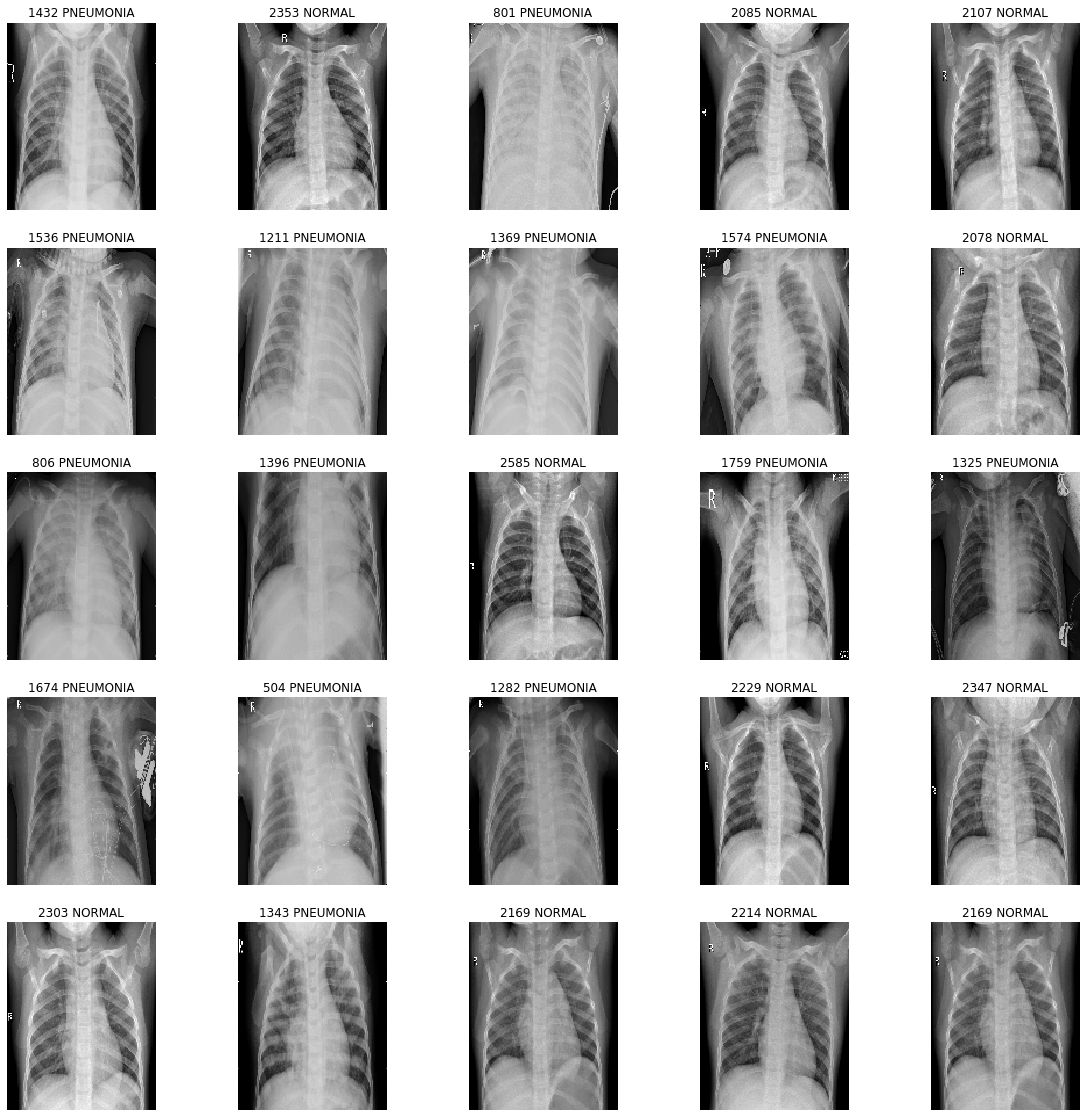

In [4]:
pltsize=4
row_images = 5
col_images = 5
plt.figure(figsize=(col_images*pltsize, row_images*pltsize))

for i in range(row_images * col_images):
    i_rand = random.randint(0, X_data.shape[0])
    plt.subplot(row_images,col_images,i+1)
    plt.axis('off')
    plt.imshow((X_data[i_rand]))
    plt.title((str(i_rand) + " " + y_data[i_rand]))

Split data into training and test partitions

In [5]:
# Perfrom split to train, validation, test of grayscaling image dataset
X_train_plus_valid, X_test, y_train_plus_valid, y_test = train_test_split(X_data_gray, y_data, random_state=0, test_size = 0.30, train_size = 0.7)


X_train, X_valid, y_train, y_valid = train_test_split(X_train_plus_valid, y_train_plus_valid, random_state=0, test_size = 0.20, train_size = 0.8)


In [6]:
y_train_pneumonia = [0 if y=='PNEUMONIA' else 1 for y in y_train]
y_test_pneumonia = [0 if y=='PNEUMONIA' else 1 for y in y_test]
unique, counts = np.unique(y_train_pneumonia, return_counts=True)
dict(zip(unique, counts))

{0: 1083, 1: 381}

In [7]:
# setting the class weight for every class to handle unbalanced dataset
class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(y_train_pneumonia),
                                                 y_train_pneumonia)

class_weights = dict(enumerate(class_weights))

In [8]:
class_weights

{0: 0.6759002770083102, 1: 1.921259842519685}

Reshape output data for use with a neural network.

In [9]:
# Convert class vectors to binary class matrices.
y_train_encoder = sklearn.preprocessing.LabelEncoder()
y_train_num = y_train_encoder.fit_transform(y_train)
y_train_wide = keras.utils.to_categorical(y_train_num, num_classes)

y_valid_num = y_train_encoder.fit_transform(y_valid)
y_valid_wide = keras.utils.to_categorical(y_valid_num, num_classes)

y_test_num = y_train_encoder.fit_transform(y_test)
y_test_wide = keras.utils.to_categorical(y_test_num, num_classes)


y_train_plus_valid_num = y_train_encoder.fit_transform(y_train_plus_valid)
y_train_plus_valid_wide = keras.utils.to_categorical(y_train_plus_valid_num, num_classes)

Record the number to label mapping 

In [10]:
classes_num_label = dict()

for idx, lbl in enumerate(y_train_encoder.classes_):
    classes_num_label[idx] = lbl

### Task2: Train a logistic regression model to perform the classification task.

In [11]:
my_model = LogisticRegression()
my_model.fit(X_train.reshape(X_train.shape[0],-1),y_train_num)
y_pred = my_model.predict(X_valid.reshape(X_valid.shape[0],-1))

accuracy1 = metrics.accuracy_score(y_valid_num, y_pred) # , normalize=True, sample_weight=None
print("Accuracy: " +  str(accuracy1))

#Cross Validation
scores = cross_val_score(my_model, X_valid.reshape(X_valid.shape[0],-1), y_valid_num , cv=10,n_jobs=-1,scoring='f1_macro')
print('Cross Validation Experiment scores With Our Model', scores.mean())


Accuracy: 0.9781420765027322


/Users/akanshakhare/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Cross Validation Experiment scores With Our Model 0.92362364021897


### Task3: Train a convolutional neural network (LeNeT-5) model to recognise pneumonia in these images.

In [12]:
cnn_model = Sequential()
cnn_model.add(Conv2D(32, (3, 3), input_shape=input_shape_gray))
cnn_model.add(Activation('relu'))
cnn_model.add(MaxPooling2D(pool_size=(2, 2)))

cnn_model.add(Conv2D(32, (3, 3)))
cnn_model.add(Activation('relu'))
cnn_model.add(MaxPooling2D(pool_size=(2, 2)))

cnn_model.add(Flatten())
cnn_model.add(Dense(256))
cnn_model.add(Activation('relu'))
cnn_model.add(Dense(120, activation = 'relu'))
cnn_model.add(Dropout(0.5))
cnn_model.add(Dense(num_classes))
cnn_model.add(Activation('softmax'))

cnn_model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

cnn_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 160, 126, 32)      320       
_________________________________________________________________
activation_1 (Activation)    (None, 160, 126, 32)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 80, 63, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 78, 61, 32)        9248      
_________________________________________________________________
activation_2 (Activation)    (None, 78, 61, 32)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 39, 30, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 37440)            

In [13]:
batch_size = 128
epochs = 20

# Set up the callback to save the best model based on validaion data

best_weights_file = './best_weights.hdf5'

mcp = ModelCheckpoint(best_weights_file, monitor="val_accuracy",
                      save_best_only=True, save_weights_only=False)

history = cnn_model.fit(X_train, y_train_wide,  # using grayscale training dataset
          batch_size=batch_size,
          epochs=epochs,
          verbose = 1,
          validation_split = 0.2,
          shuffle=True,
          callbacks=[mcp],
          class_weight=class_weights)


#reload best weights
cnn_model.load_weights("best_weights.hdf5")

Train on 1171 samples, validate on 293 samples
Epoch 1/20
1171/1171 [==============================] - 19s 16ms/step - loss: 0.7879 - accuracy: 0.6985 - val_loss: 0.5086 - val_accuracy: 0.7713
Epoch 2/20
1171/1171 [==============================] - 18s 16ms/step - loss: 0.5496 - accuracy: 0.7319 - val_loss: 0.3796 - val_accuracy: 0.7713
Epoch 3/20
1171/1171 [==============================] - 24s 21ms/step - loss: 0.3721 - accuracy: 0.7865 - val_loss: 0.3075 - val_accuracy: 0.8157
Epoch 4/20
1171/1171 [==============================] - 22s 19ms/step - loss: 0.2917 - accuracy: 0.8591 - val_loss: 0.2793 - val_accuracy: 0.9420
Epoch 5/20
1171/1171 [==============================] - 21s 18ms/step - loss: 0.2343 - accuracy: 0.9069 - val_loss: 0.1970 - val_accuracy: 0.9454
Epoch 6/20
1171/1171 [==============================] - 19s 16ms/step - loss: 0.1564 - accuracy: 0.9394 - val_loss: 0.1391 - val_accuracy: 0.9590
Epoch 7/20
1171/1171 [==============================] - 21s 18ms/step - loss:

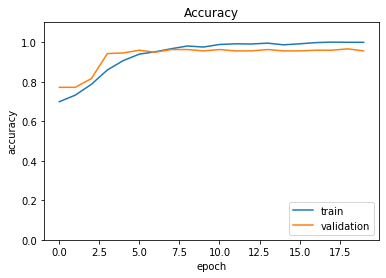

In [14]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower right')
plt.ylim((0, 1.1))
plt.show()

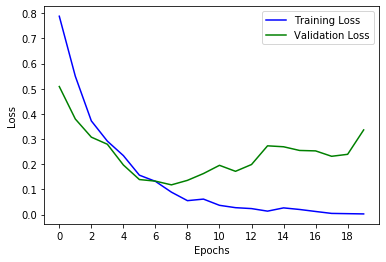

In [15]:
# summarize history for loss
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(loss, 'blue', label='Training Loss')
plt.plot(val_loss, 'green', label='Validation Loss')
plt.xticks(range(0,epochs)[0::2])
plt.legend()
plt.show()

In [16]:
# Make a set of predictions for the training data
pred = cnn_model.predict_classes(X_train)

# Print performance details
print(metrics.classification_report(y_train_num, pred))
print("Confusion matrix")
print(metrics.confusion_matrix(y_train_num, pred))

              precision    recall  f1-score   support

           0       0.98      0.99      0.99       381
           1       1.00      0.99      1.00      1083

    accuracy                           0.99      1464
   macro avg       0.99      0.99      0.99      1464
weighted avg       0.99      0.99      0.99      1464

Confusion matrix
[[ 377    4]
 [   6 1077]]


### Evaluating CNN(LeNeT-5) Model Performance

In [17]:
# Make a set of predictions for the validation data
pred = cnn_model.predict_classes(X_valid)

# Print performance details
print(metrics.classification_report(y_valid_num, pred))
print("Confusion matrix")
print(metrics.confusion_matrix(y_valid_num, pred))

              precision    recall  f1-score   support

           0       0.95      0.92      0.94        78
           1       0.98      0.99      0.98       288

    accuracy                           0.97       366
   macro avg       0.96      0.95      0.96       366
weighted avg       0.97      0.97      0.97       366

Confusion matrix
[[ 72   6]
 [  4 284]]


### Task4: Data Augmentation techniques

#### Technique 1: Horizontal shift Augmentation

In [18]:
model1 = Sequential()
model1.add(Conv2D(32, (3, 3), input_shape=input_shape))
model1.add(Activation('relu'))
model1.add(MaxPooling2D(pool_size=(2, 2)))

model1.add(Conv2D(32, (3, 3)))
model1.add(Activation('relu'))
model1.add(MaxPooling2D(pool_size=(2, 2)))

model1.add(Flatten())
model1.add(Dense(256, activation = 'relu'))
model1.add(Dense(120, activation = 'relu'))
model1.add(Dropout(0.5))
model1.add(Dense(num_classes, activation = 'softmax'))

model1.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model1.summary()

# Perform split to train, validation, test of original image dataset
X_train_plus_valid, X_test, y_train_plus_valid, y_test = train_test_split(X_data, y_data, random_state=0, test_size = 0.30, train_size = 0.7)

X_train, X_valid, y_train, y_valid = train_test_split(X_train_plus_valid, y_train_plus_valid, random_state=0, test_size = 0.20, train_size = 0.8)


# Convert class vectors to binary class matrices.
y_train_encoder = sklearn.preprocessing.LabelEncoder()
y_train_num = y_train_encoder.fit_transform(y_train)
y_train_wide = keras.utils.to_categorical(y_train_num, num_classes)

y_valid_num = y_train_encoder.fit_transform(y_valid)
y_valid_wide = keras.utils.to_categorical(y_valid_num, num_classes)

y_test_num = y_train_encoder.fit_transform(y_test)
y_test_wide = keras.utils.to_categorical(y_test_num, num_classes)

batch_size = 128
epochs = 20

# Set up the callback to save the best model based on validaion data
best_weights_file = './best_weights1.hdf5'

mcp = ModelCheckpoint(best_weights_file, monitor="val_accuracy",
                      save_best_only=True, save_weights_only=False)

# Create a data generator for the trianing data
datagen_train = ImageDataGenerator(
    featurewise_center=False,
    featurewise_std_normalization=False,
    width_shift_range=[-200,200])
datagen_train.fit(X_train)
        
history = model1.fit_generator(datagen_train.flow(X_train, y_train_wide, batch_size=batch_size),
          steps_per_epoch=None,
          validation_data=(X_valid, y_valid_wide),
          epochs=epochs,
          verbose = 1,
          shuffle=True,
          callbacks=[mcp])


#reload best weights
model1.load_weights("best_weights1.hdf5")


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 160, 126, 32)      896       
_________________________________________________________________
activation_5 (Activation)    (None, 160, 126, 32)      0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 80, 63, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 78, 61, 32)        9248      
_________________________________________________________________
activation_6 (Activation)    (None, 78, 61, 32)        0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 39, 30, 32)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 37440)            

In [19]:
# Make a set of predictions for the validation data
pred = model1.predict_classes(X_valid)

# Print performance details
print(metrics.classification_report(y_valid_num, pred))
print("Confusion matrix")
print(metrics.confusion_matrix(y_valid_num, pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        78
           1       0.79      1.00      0.88       288

    accuracy                           0.79       366
   macro avg       0.39      0.50      0.44       366
weighted avg       0.62      0.79      0.69       366

Confusion matrix
[[  0  78]
 [  0 288]]


/Users/akanshakhare/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#### Technique 2: Random Rotation Augmentation

In [20]:
model2 = Sequential()
model2.add(Conv2D(32, (3, 3), input_shape=input_shape))
model2.add(Activation('relu'))
model2.add(MaxPooling2D(pool_size=(2, 2)))

model2.add(Conv2D(32, (3, 3)))
model2.add(Activation('relu'))
model2.add(MaxPooling2D(pool_size=(2, 2)))

model2.add(Flatten())
model2.add(Dense(256, activation = 'relu'))
model2.add(Dense(120, activation = 'relu'))
model2.add(Dropout(0.5))
model2.add(Dense(num_classes, activation = 'softmax'))

model2.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model2.summary()


# Perform split to train, validation, test of original image dataset
X_train_plus_valid, X_test, y_train_plus_valid, y_test = train_test_split(X_data, y_data, random_state=0, test_size = 0.30, train_size = 0.7)

X_train, X_valid, y_train, y_valid = train_test_split(X_train_plus_valid, y_train_plus_valid, random_state=0, test_size = 0.20, train_size = 0.8)


# Convert class vectors to binary class matrices.
y_train_encoder = sklearn.preprocessing.LabelEncoder()
y_train_num = y_train_encoder.fit_transform(y_train)
y_train_wide = keras.utils.to_categorical(y_train_num, num_classes)

y_valid_num = y_train_encoder.fit_transform(y_valid)
y_valid_wide = keras.utils.to_categorical(y_valid_num, num_classes)

y_test_num = y_train_encoder.fit_transform(y_test)
y_test_wide = keras.utils.to_categorical(y_test_num, num_classes)


batch_size = 128
epochs = 20

# Set up the callback to save the best model based on validaion data
best_weights_file = './best_weights2.hdf5'

mcp = ModelCheckpoint(best_weights_file, monitor="val_accuracy",
                      save_best_only=True, save_weights_only=False)

# Create a data generator for the trianing data
datagen_train = ImageDataGenerator(rotation_range=20)
        
history = model2.fit_generator(datagen_train.flow(X_train, y_train_wide, batch_size=batch_size),
          steps_per_epoch=None,
          validation_data=(X_valid, y_valid_wide),
          epochs=epochs,
          verbose = 1,
          shuffle=True,
          callbacks=[mcp])


#reload best weights
model2.load_weights("best_weights2.hdf5")


Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 160, 126, 32)      896       
_________________________________________________________________
activation_7 (Activation)    (None, 160, 126, 32)      0         
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 80, 63, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 78, 61, 32)        9248      
_________________________________________________________________
activation_8 (Activation)    (None, 78, 61, 32)        0         
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 39, 30, 32)        0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 37440)            

In [21]:
# Make a set of predictions for the validation data
pred = model2.predict_classes(X_valid)

# Print performance details
print(metrics.classification_report(y_valid_num, pred))
print("Confusion matrix")
print(metrics.confusion_matrix(y_valid_num, pred))

              precision    recall  f1-score   support

           0       0.94      0.95      0.94        78
           1       0.99      0.98      0.98       288

    accuracy                           0.98       366
   macro avg       0.96      0.97      0.96       366
weighted avg       0.98      0.98      0.98       366

Confusion matrix
[[ 74   4]
 [  5 283]]


#### Technique 3:  zoom_range Augmentation

In [22]:
model3 = Sequential()
model3.add(Conv2D(32, (3, 3), input_shape=input_shape))
model3.add(Activation('relu'))
model3.add(MaxPooling2D(pool_size=(2, 2)))

model3.add(Conv2D(32, (3, 3)))
model3.add(Activation('relu'))
model3.add(MaxPooling2D(pool_size=(2, 2)))

model3.add(Flatten())
model3.add(Dense(256, activation = 'relu'))
model3.add(Dense(120, activation = 'relu'))
model3.add(Dropout(0.5))
model3.add(Dense(num_classes, activation = 'softmax'))

model3.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model3.summary()

# Perform split to train, validation, test of original image dataset
X_train_plus_valid, X_test, y_train_plus_valid, y_test = train_test_split(X_data, y_data, random_state=0, test_size = 0.30, train_size = 0.7)

X_train, X_valid, y_train, y_valid = train_test_split(X_train_plus_valid, y_train_plus_valid, random_state=0, test_size = 0.20, train_size = 0.8)


# Convert class vectors to binary class matrices.
y_train_encoder = sklearn.preprocessing.LabelEncoder()
y_train_num = y_train_encoder.fit_transform(y_train)
y_train_wide = keras.utils.to_categorical(y_train_num, num_classes)

y_valid_num = y_train_encoder.fit_transform(y_valid)
y_valid_wide = keras.utils.to_categorical(y_valid_num, num_classes)

y_test_num = y_train_encoder.fit_transform(y_test)
y_test_wide = keras.utils.to_categorical(y_test_num, num_classes)

batch_size = 128
epochs = 20

# Set up the callback to save the best model based on validaion data
best_weights_file = './best_weights3.hdf5'

mcp = ModelCheckpoint(best_weights_file, monitor="val_accuracy",
                      save_best_only=True, save_weights_only=False)

# Create a data generator for the trianing data
datagen_train = ImageDataGenerator(zoom_range=[0.5,1])
        
history = model3.fit_generator(datagen_train.flow(X_train, y_train_wide, batch_size=batch_size),
          steps_per_epoch=None,
          validation_data=(X_valid, y_valid_wide),
          epochs=epochs,
          verbose = 1,
          shuffle=True,
          callbacks=[mcp])


#reload best weights
model3.load_weights("best_weights3.hdf5")


Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 160, 126, 32)      896       
_________________________________________________________________
activation_9 (Activation)    (None, 160, 126, 32)      0         
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 80, 63, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 78, 61, 32)        9248      
_________________________________________________________________
activation_10 (Activation)   (None, 78, 61, 32)        0         
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 39, 30, 32)        0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 37440)            

In [23]:
# Make a set of predictions for the validation data
pred = model3.predict_classes(X_valid)

# Print performance details
print(metrics.classification_report(y_valid_num, pred))
print("Confusion matrix")
print(metrics.confusion_matrix(y_valid_num, pred))

              precision    recall  f1-score   support

           0       0.79      0.82      0.81        78
           1       0.95      0.94      0.95       288

    accuracy                           0.92       366
   macro avg       0.87      0.88      0.88       366
weighted avg       0.92      0.92      0.92       366

Confusion matrix
[[ 64  14]
 [ 17 271]]


### Task5: Building VGG16 Model

In [24]:
# Perform split to train, validation, test  of original image dataset
X_train_plus_valid, X_test, y_train_plus_valid, y_test = train_test_split(X_data, y_data, random_state=0, test_size = 0.30, train_size = 0.7)

X_train, X_valid, y_train, y_valid = train_test_split(X_train_plus_valid, y_train_plus_valid, random_state=0, test_size = 0.20, train_size = 0.8)


# Convert class vectors to binary class matrices.
y_train_encoder = sklearn.preprocessing.LabelEncoder()
y_train_num = y_train_encoder.fit_transform(y_train)
y_train_wide = keras.utils.to_categorical(y_train_num, num_classes)

y_valid_num = y_train_encoder.fit_transform(y_valid)
y_valid_wide = keras.utils.to_categorical(y_valid_num, num_classes)

y_test_num = y_train_encoder.fit_transform(y_test)
y_test_wide = keras.utils.to_categorical(y_test_num, num_classes)


y_train_plus_valid_num = y_train_encoder.fit_transform(y_train_plus_valid)
y_train_plus_valid_wide = keras.utils.to_categorical(y_train_plus_valid_num, num_classes)

classes_num_label = dict()
for idx, lbl in enumerate(y_train_encoder.classes_):
    classes_num_label[idx] = lbl
    
    
# build the VGG16 network
vgg16_model = keras.applications.VGG16(weights='imagenet', include_top=False, input_shape = X_train[0].shape)
display(vgg16_model.summary())

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 162, 128, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 162, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 162, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 81, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 81, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 81, 64, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 40, 32, 128)       0     

None

In [25]:
vgg16_last_layer = vgg16_model.output

# build a classifier model to put on top of the VGG16 model
x1 = Flatten()(vgg16_last_layer)
x2 = Dense(256, activation='relu')(x1)
x3 = Dropout(0.5)(x2)
final_layer = Dense(num_classes, activation = 'softmax')(x3)

# Assemble the full model out of both parts
full_model = keras.Model(vgg16_model.input, final_layer)


# set the first 15 layers (up to the third last conv block) to non-trainable (weights will not be updated)
for layer in full_model.layers[:15]:
    layer.trainable = False

# compile the model with a SGD/momentum optimizer.
full_model.compile(loss='binary_crossentropy',
              optimizer=keras.optimizers.SGD(lr=1e-4, momentum=0.9),
              metrics=['accuracy'])

full_model.summary()

batch_size = 128
epochs = 20

# Set up the callback to save the best model based on validaion data
best_weights_filepath = './best_weights4.hdf5'
mcp = ModelCheckpoint(best_weights_filepath, monitor="val_loss",
                      save_best_only=True, save_weights_only=False)

history = full_model.fit(X_train, y_train_wide,
          batch_size=batch_size,
          epochs=epochs,
          verbose = 1,
          validation_split = 0.2,
          shuffle=True,
          callbacks=[mcp])

#reload best weights
full_model.load_weights('best_weights4.hdf5')

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 162, 128, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 162, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 162, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 81, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 81, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 81, 64, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 40, 32, 128)       0   

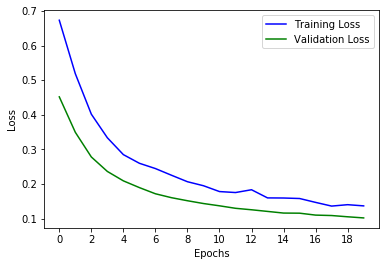

In [26]:
# summarize history for loss
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(loss, 'blue', label='Training Loss')
plt.plot(val_loss, 'green', label='Validation Loss')
plt.xticks(range(0,epochs)[0::2])
plt.legend()
plt.show()

### Evaluating VGG16 Model Performance

In [27]:
# Make a set of predictions for the validation data
pred = np.argmax(full_model.predict(X_valid),axis=1)

# Print performance details
print(metrics.classification_report(y_valid_num, pred))
print("Confusion matrix")
print(metrics.confusion_matrix(y_valid_num, pred))

              precision    recall  f1-score   support

           0       0.92      0.91      0.92        78
           1       0.98      0.98      0.98       288

    accuracy                           0.96       366
   macro avg       0.95      0.94      0.95       366
weighted avg       0.96      0.96      0.96       366

Confusion matrix
[[ 71   7]
 [  6 282]]


### Task6: Compare the performance of the 4 models built in parts 2 to 5 using the supplied test set. Write a reflection on the results of this comparison. 

#### Loading image data from supplied test set


In [28]:
dataset_name = 'test/'

# assuming data is contained in a test set
test_data_dir = dataset_name

# Set up some parameters for data loading
sample_rate = 1

# desired dimensions of our images.
img_width, img_height = 162, 128

if K.image_data_format() == 'channels_first':
    input_shape = (3, img_width, img_height)
    input_shape_gray = (1,img_width, img_height)
else:
    input_shape = (img_width, img_height,3)
    input_shape_gray = (img_width, img_height,1)
    

test_class_folders = [i for i in os.listdir(test_data_dir) if not i.startswith('.')] # use this for full dataset
num_classes = len(test_class_folders)

# Initialise arrays for data storage
X_test = np.ndarray((0, input_shape[0], input_shape[1], input_shape[2]), dtype=np.float)
y_test= np.ndarray(0, dtype=np.str)
X_test_gray = np.ndarray((0,input_shape_gray[0],input_shape_gray[1],input_shape_gray[2]),dtype=np.float)

    
# Loop through the class folders
for i, image_cls in enumerate(test_class_folders):
    
    print('Processing class {}'.format(image_cls))
    image_class_folder = test_data_dir + image_cls + "/"

    # generate filenames from the data folder and do sampling
    image_filenames = [image_class_folder+i for i in os.listdir(image_class_folder) if not i.startswith('.')] # use this for full dataset
    image_filenames = random.sample(image_filenames, int(len(image_filenames)*sample_rate))

    # Create a data array for image data
    count = len(image_filenames)
    X_data_part = np.ndarray((count, input_shape[0], input_shape[1], input_shape[2]), dtype=np.float)
    X_data_part_gray = np.ndarray((count, input_shape_gray[0], input_shape_gray[1], input_shape_gray[2]), dtype=np.float)
   
    # Iterate through the filenames and for each one load the image, resize and normalise
    for i, image_file in enumerate(image_filenames):

        # Load the images and resize them. 
        image = cv2.imread(image_file, cv2.IMREAD_COLOR)
        image_color = cv2.resize(image, (img_height, img_width), interpolation=cv2.INTER_CUBIC)
        image_color = image_color[:,:,[2,1,0]] 
        
        
        #gray scale image for Logistic Regression and CNN model
        
        image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        image_gray = cv2.resize(image_gray,(img_height, img_width), interpolation=cv2.INTER_CUBIC)
        image_gray = np.asarray(image_gray).reshape(image_gray.shape[0],image_gray.shape[1],1)
        
        # If channel order of network does not match open cv format swap it
        if K.image_data_format() == 'channels_first':
            image_color=np.swapaxes(np.swapaxes(image_color, 1, 2), 0, 1)
            image_gray=np.swapaxes(np.swapaxes(image_gray, 1, 2), 0, 1)
             
        # Add image data to data array and normalise
        X_data_part[i] = image_color
        X_data_part[i] = X_data_part[i]/255
        X_data_part_gray[i] = image_gray
        X_data_part_gray[i] = X_data_part_gray[i]/255
        
        
        # Add label to label array
        y_test = np.append(y_test, image_cls)
        
        if i%100 == 0: print('Processed {} of {} for class {} '.format(i, count, image_cls))

    print('Processed {} of {} for class {} '.format(i + 1, count, image_cls))
    
    # Append the part to the overall data array
    X_test = np.append(X_test, X_data_part, axis=0)
    X_test_gray = np.append(X_test_gray, X_data_part_gray, axis=0)
print("Data shape: {}".format(X_test.shape))
print("Data shape: {}".format(X_test_gray.shape))

Processing class PNEUMONIA
Processed 0 of 390 for class PNEUMONIA 
Processed 100 of 390 for class PNEUMONIA 
Processed 200 of 390 for class PNEUMONIA 
Processed 300 of 390 for class PNEUMONIA 
Processed 390 of 390 for class PNEUMONIA 
Processing class NORMAL
Processed 0 of 234 for class NORMAL 
Processed 100 of 234 for class NORMAL 
Processed 200 of 234 for class NORMAL 
Processed 234 of 234 for class NORMAL 
Data shape: (624, 162, 128, 3)
Data shape: (624, 162, 128, 1)


In [29]:
# Convert class vectors to binary class matrices.
y_test_encoder = sklearn.preprocessing.LabelEncoder()
y_test_num = y_train_encoder.fit_transform(y_test)
y_test_wide = keras.utils.to_categorical(y_train_num, num_classes)

# Make a set of predictions for the test data using Logistic Regression model
y_pred = my_model.predict(X_test_gray.reshape(X_test_gray.shape[0],-1))
accuracy1 = metrics.accuracy_score(y_test_num, y_pred) # , normalize=True, sample_weight=None
print("Logistic Regression Accuracy: " +  str(accuracy1))


# Make a set of predictions for the test data using CNN model
pred1 = cnn_model.predict_classes(X_test_gray)
# Print performance details
print("************* CNN(LeNet-5) Accuracy: **********\n",metrics.classification_report(y_test_num, pred1))


# Make a set of predictions for the test data using Horizontal Shift Augmentation
pred2 = model1.predict_classes(X_test)
# Print performance details
print("********** Horizontal Shift Augmentation Accuracy: ***********\n ",metrics.classification_report(y_test_num, pred2))


# Make a set of predictions for the test data using Random Rotation Augmentation
pred3 = model2.predict_classes(X_test)
# Print performance details
print("********* Random Rotation Augmentation Accuracy: ************\n ",metrics.classification_report(y_test_num, pred3))


# Make a set of predictions for the test data using Zoom_range Augmentation
pred4 = model3.predict_classes(X_test)
# Print performance details
print("********** Zoom_range Augmentation Accuracy: ****************\n ",metrics.classification_report(y_test_num, pred4))


# Make a set of predictions for the validation data using VGG16 model
pred5 = np.argmax(full_model.predict(X_test),axis=1)
# Print performance details
print("**************** VGG16 Accuracy: *******************\n ",metrics.classification_report(y_test_num, pred5))

Logistic Regression Accuracy: 0.7403846153846154
************* CNN(LeNet-5) Accuracy: **********
               precision    recall  f1-score   support

           0       0.96      0.31      0.47       234
           1       0.71      0.99      0.83       390

    accuracy                           0.74       624
   macro avg       0.83      0.65      0.65       624
weighted avg       0.80      0.74      0.69       624



/Users/akanshakhare/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


********** Horizontal Shift Augmentation Accuracy: ***********
                precision    recall  f1-score   support

           0       0.00      0.00      0.00       234
           1       0.62      1.00      0.77       390

    accuracy                           0.62       624
   macro avg       0.31      0.50      0.38       624
weighted avg       0.39      0.62      0.48       624

********* Random Rotation Augmentation Accuracy: ************
                precision    recall  f1-score   support

           0       0.95      0.39      0.55       234
           1       0.73      0.99      0.84       390

    accuracy                           0.76       624
   macro avg       0.84      0.69      0.70       624
weighted avg       0.81      0.76      0.73       624

********** Zoom_range Augmentation Accuracy: ****************
                precision    recall  f1-score   support

           0       0.93      0.62      0.75       234
           1       0.81      0.97      0.88 

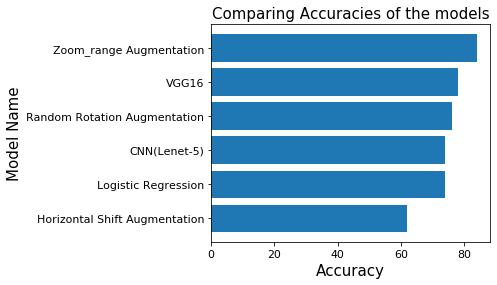

In [31]:
x = [62,74,74,76,78,84]
y = ['Horizontal Shift Augmentation','Logistic Regression','CNN(Lenet-5)','Random Rotation Augmentation','VGG16','Zoom_range Augmentation']


plt.figure(figsize=(5,4))
plt.barh(y,x, align="center")
plt.title("Comparing Accuracies of the models",fontsize=15)
plt.xlabel('Accuracy',fontsize=15)
plt.ylabel('Model Name',fontsize=15)
plt.rcParams.update({'font.size': 11})
plt.show()

From an above bar chart, we can see that data augmentation model and VGG16 model performed well among rest of the models to recognise pneumonia from test dataset of chest x-ray images.

- Data augmentation is a technique to artificially create new training data from existing training data. This is done by applying domain-specific techniques like horizontal shift augmentation, zoom range augmentation, random rotation augmentation to examples from the training data that create new and different training examples. It's precision and recall rate of 'NORMAL' is higher than 'PNEUMONIA'. CNN model with horizontal shift augmentation technique is having very low accuracy i.e. 62% on an unseen data and it is having zero precision and recall rate of 'PNEUMONIA'. 

- A pre-trained VGG 16 model is a convolution neural net (CNN) architecture model that has been previously trained on a ImageNet dataset and contains the weights and biases that represent the features of ImageNet dataset it was trained on. It is having one unfreeze CNN layer as well as dense layers which means weights can be updated. This model takes time and require an entire network to be trained. It is having a very less validation loss and 78% accuracy on an unseen data which is greater than CNN(Lenet-5) model and Logistic Regression model. It's precision rate of 'PNEUMONIA' and recall rate of 'NORMAL' are very high i.e. 98% and 99% respectively. Whereas, recall rate of 'PNEUMONIA' is very low i.e. 43%

- CNN(Lenet-5) model and Logistic Regression model both are having almost similar accuracy i.e. 74% and 74% respectively on test dataset. CNN(Lenet-5) model is trained on grayscale image dataset which is having only one channel. And, it can handle class imbalance in the dataset. Logistic regression is a binary classification method that is why color image is first converted into grayscale image which is then converted to binary image.

#### Conclusion:
I would say that VGG16 model is the best model for chest x-ray dataset to detect whether the chest x-ray is 'NORMAL' or 'PNEUMONIA'. Because it is having good accuracy on unseen data. The recall rate of 'NORMAL' is higher than 'PNEUMONIA'. Although, the precision rate of 'NORMAL' and 'PNEUMONIA' is greater than 70%.